# Things that need preparing
## CHANGE_SSL_METHOD
### change_for_archiecture

* old resnet **DONE**
* new resnet **DONE**

****

### SSL methods used

* Barlow_twins **DONE**
* simsiam **DONE**
* supcon **DONE**
* swav **DONE**

****

## Domain adaptation 
* MNISIT **DONE**
* MNISIT_MIX **DONE**


In [1]:
from models.resnet import ResNet, BasicBlock, resnet_sim
from torchsummary import summary

model= resnet_sim( 5, 5).cuda()
print(model)
# print(summary(model, (3, 32, 32), batch_size=256))

resnet_sim(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (

In [2]:
model = ResNet(BasicBlock, [2, 2, 2, 2], 5, 5).cuda()
print(model)

# print(summary(model, (3, 32, 32), batch_size=256))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [6]:
import wandb

from utils.util import BCE, PairEnum, cluster_acc, Identity, AverageMeter, seed_torch,accuracy
from data.cifarloader import CIFAR10Loader, CIFAR10LoaderMix, CIFAR100Loader, CIFAR100LoaderMix
from models.resnet import ResNet, BasicBlock
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, lr_scheduler
import numpy as np
from tqdm import tqdm
import pandas as pd


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# all these conditions for cifar 10 
seed_torch(0)
num_labeled_classes=5
num_unlabeled_classes=5
num_classes = num_labeled_classes + num_unlabeled_classes
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [9]:
api = wandb.Api()# used to import weight and bias pipeline


## STEP 3
## Change of architecutre

In [10]:
## STEP 1
run_old_SSL = api.run("mhaggag96/trends_project/1ni39qdj").history()
run_new_SSL = api.run("mhaggag96/trends_project/1o6drm9k").history()
run_old_SSL_model = 'data/experiments/selfsupervised_learning/rotnet_cifar10_basicconfig.pth'
run_new_SSL_model = 'data/experiments/selfsupervised_learning/rotnet_cifar10_new_config.pth'



### analysis on SSL step 

In [11]:
from selfsupervised_learning import resnet_sim
from models.resnet import BasicBlock
from selfsupervised_learning import test


In [12]:
global is_adapters  # TODO: Does anyone know what is the use of this??? what happens if I change its value ????
is_adapters = 0
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # Initial Convolution + BatchNormalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        # Append ResNet18 layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        # Implement a final linear layer to classify between the given classes. This head will be used only to perform
        # this unsupervised classification task (RotNet), and will be removed in the next task (Supervised training)
        self.linear = nn.Linear(512 * block.expansion, num_classes)
        # If is_adapters is true then add a parallel_convolution layer
        if is_adapters:  # Not used since adapters is set to 0
            self.parallel_conv1 = nn.Conv2d(3, 64, kernel_size=1, stride=1, bias=False)

    def _make_layer(self, block, planes, num_blocks, stride):
        # Compute a strides list for the different blocks. Use the input argument stride for the first block
        # (this allows to reduce the dimension if it is >1), then use stride=1 for all the other layers in the block
        strides = [stride] + [1] * (num_blocks - 1)
        # Define an empty list of layers
        layers = []
        # Each layer is composed of a set of blocks with the previously defined strides
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion  # Block expansion is set to 1 in the BasicBlock class
        return nn.Sequential(*layers)

    def forward(self, x):
        # Compute the output of the NN
        # If is adapters is true consider also the parallel convolution in the computation of the output
        if is_adapters:  # TODO:How is is_adapters used and defined??
            out = F.relu(self.bn1(self.conv1(x) + self.parallel_conv1(x)))
        # Otherwise consider just the previous layers
        else:
            out = F.relu(self.bn1(self.conv1(x)))
        # Compute the output through all the ResNet layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [13]:
from data.rotationloader import DataLoader, GenericDataset
dataset_test = GenericDataset(
            dataset_name='cifar10',
            split='test',
            dataset_root='./data/datasets/CIFAR/'
        )
dloader_test = DataLoader(
            dataset=dataset_test,
            batch_size=64,
            num_workers=4,
            shuffle=False)

Files already downloaded and verified


In [14]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=4)
model.load_state_dict(torch.load(run_old_SSL_model))
model_2 = resnet_sim(num_labeled_classes=4)
model_2.load_state_dict(torch.load(run_new_SSL_model))

<All keys matched successfully>

In [15]:
def test(model, device, dataloader, epoch):
    # Define an instance of AverageMeter to compute and store the average and current values of the accuracy
    acc_record = AverageMeter()
    # Put the model in evaluation mode
    model.eval()
    # Iterate through the dataloader using tqdm to print a graphic progress bar
    for batch_idx, (data, label) in enumerate(tqdm(dataloader())):
        # Move both data and label to gpu, the data has input (256,3,32,32)
        data, label = data.to(device), label.to(device)
        # Compute the output of the model for the input data. Output dimension (256,4)
        output = model(data)

        # Compute the accuracy using the accuracy() function from the file utils.py
        # Also in this call the argument 'topk' is not passed, so it is set to default value of (1,)
        acc = accuracy(output, label)
        # Update the accuracy AverageMeter object with the values just computed
        acc_record.update(acc[0].item(), data.size(0))

    # Print the result of the testing procedure
    print('Test Acc: {:.4f}'.format(acc_record.avg))
    return acc_record

In [16]:
model.to(device)
acc_record = test(model, device, dloader_test, 0)


100%|█████████████████████████████████████████| 157/157 [00:07<00:00, 19.72it/s]

Test Acc: 96.0850


In [17]:
model_2.to(device)
acc_record = test(model_2, device, dloader_test, 0)


100%|█████████████████████████████████████████| 157/157 [00:07<00:00, 20.44it/s]

Test Acc: 95.5500


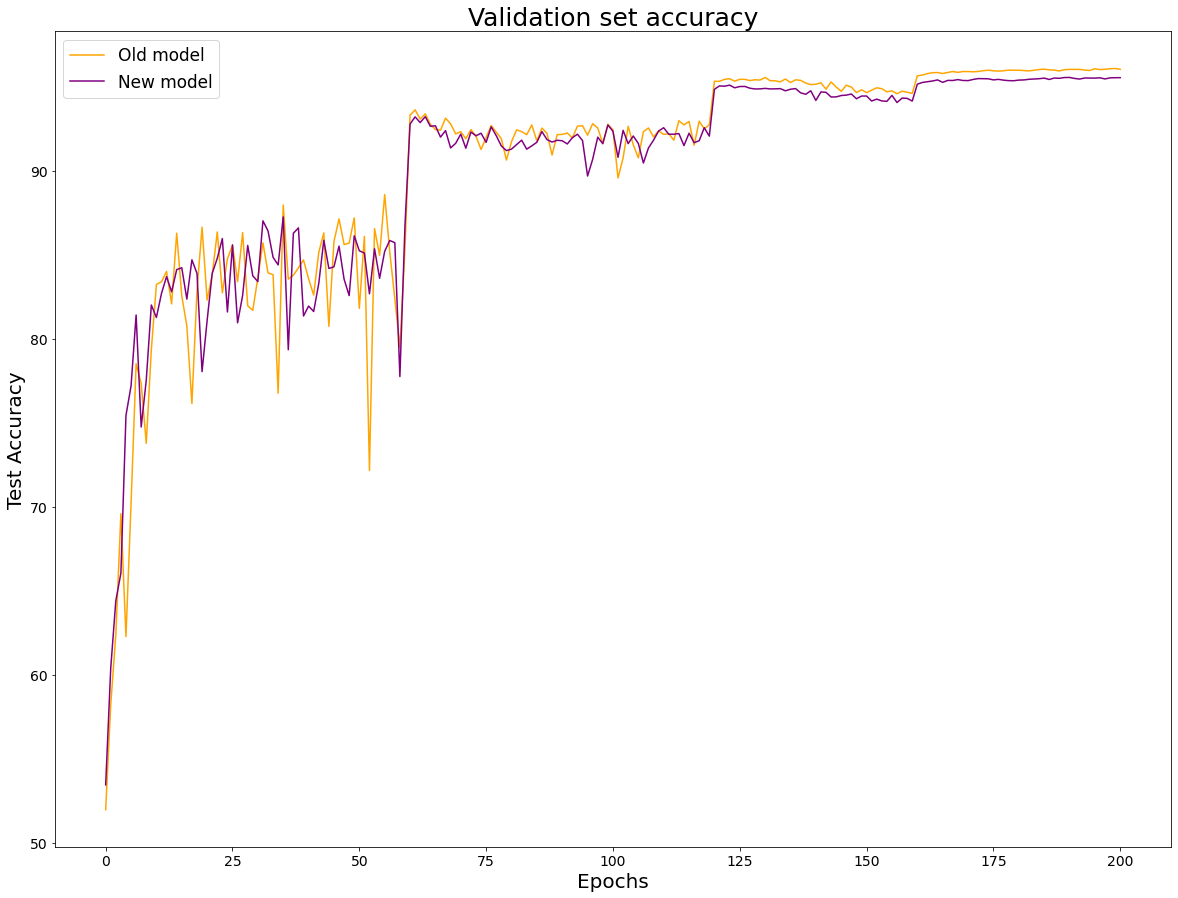

In [18]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_SSL.Head_1_val_accuracy.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_SSL.Head_1_val_accuracy.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Test Accuracy',fontsize=20);
ax.set_title('Validation set accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)

plt.show()

### anaylsis of SL

In [19]:
from models.resnet import BasicBlock,resnet_sim,ResNet
from utils.util import cluster_acc, Identity, AverageMeter, accuracy
from data.cifarloader import CIFAR10Loader, CIFAR10LoaderMix

In [20]:
## STEP 2
run_old_SL = api.run("mhaggag96/trends_project/vp78kjp8").history()
run_new_SL = api.run("mhaggag96/trends_project/2sderoky").history()
run_old_SL_model = 'data/experiments/supervised_learning/resnet_rotnet_cifar10_basicconfig.pth'
run_new_SL_model = 'data/experiments/supervised_learning/resnet_rotnet_cifar10_new_config.pth'

In [21]:
model=ResNet(BasicBlock, [2, 2, 2, 2], 5, 5).to(device)
model.load_state_dict(torch.load(run_old_SL_model))
model_2 = resnet_sim(5, 5).to(device)
model_2.load_state_dict(torch.load(run_new_SL_model))

<All keys matched successfully>

In [22]:
def test(model, test_loader):
    model.eval()
    preds = np.array([])
    targets = np.array([])
    acc_record = AverageMeter()  # track the accuracy of the first head

    for batch_idx, (x, label, _) in enumerate(tqdm(test_loader)):
        x, label = x.to(device), label.to(device)
        output1, output2, _ = model(x)
        output = output1
        _, pred = output.max(1)
        acc_testing = accuracy(output, label)  # calculating the accuracy
        acc_record.update(acc_testing[0].item(), x.size(0))
        targets = np.append(targets, label.cpu().numpy())
        preds = np.append(preds, pred.cpu().numpy())
    acc, nmi, ari = cluster_acc(targets.astype(int), preds.astype(int)), nmi_score(targets, preds), ari_score(targets,
                                                                                                              preds)
    print('Test cluster acc {:.4f}, nmi {:.4f}, ari {:.4f}, test accuracy {:.4f}'.format(acc, nmi, ari, acc_record.avg))
    return acc, nmi, ari, acc_record.avg

In [23]:
labeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                            aug=None, shuffle=False, target_list=range(5))

In [24]:
acc_H1, nmi_H1, ari_H1, acc_testing_H1 =test(model, labeled_eval_loader)


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.20it/s]

Test cluster acc 0.9584, nmi 0.8694, ari 0.8994, test accuracy 95.8400


In [25]:
acc_H1, nmi_H1, ari_H1, acc_testing_H1 =test(model_2, labeled_eval_loader)


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 33.19it/s]


Test cluster acc 0.9476, nmi 0.8421, ari 0.8744, test accuracy 94.7600


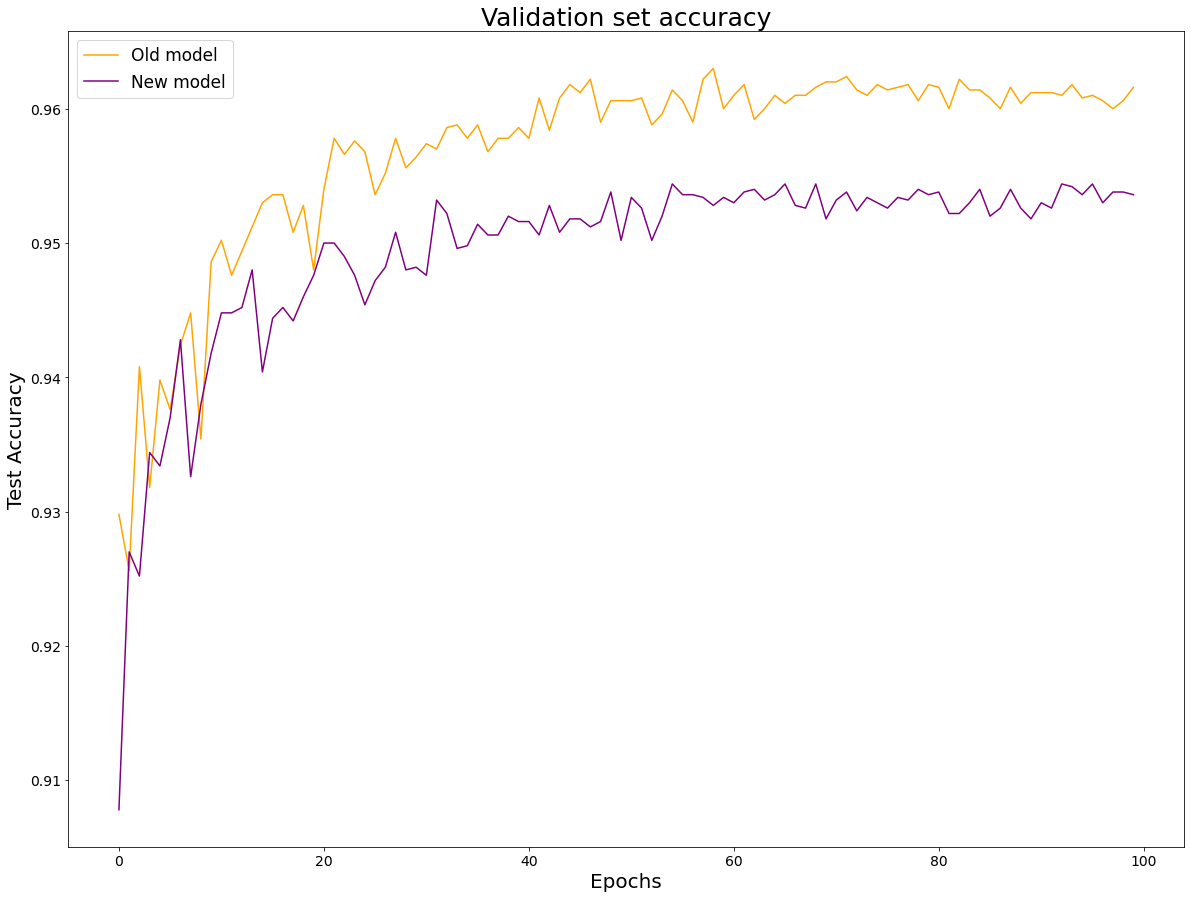

In [26]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_SL.cluster_acc_Head_1.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_SL.cluster_acc_Head_1.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Test Accuracy',fontsize=20);
ax.set_title('Validation set accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)

plt.show()

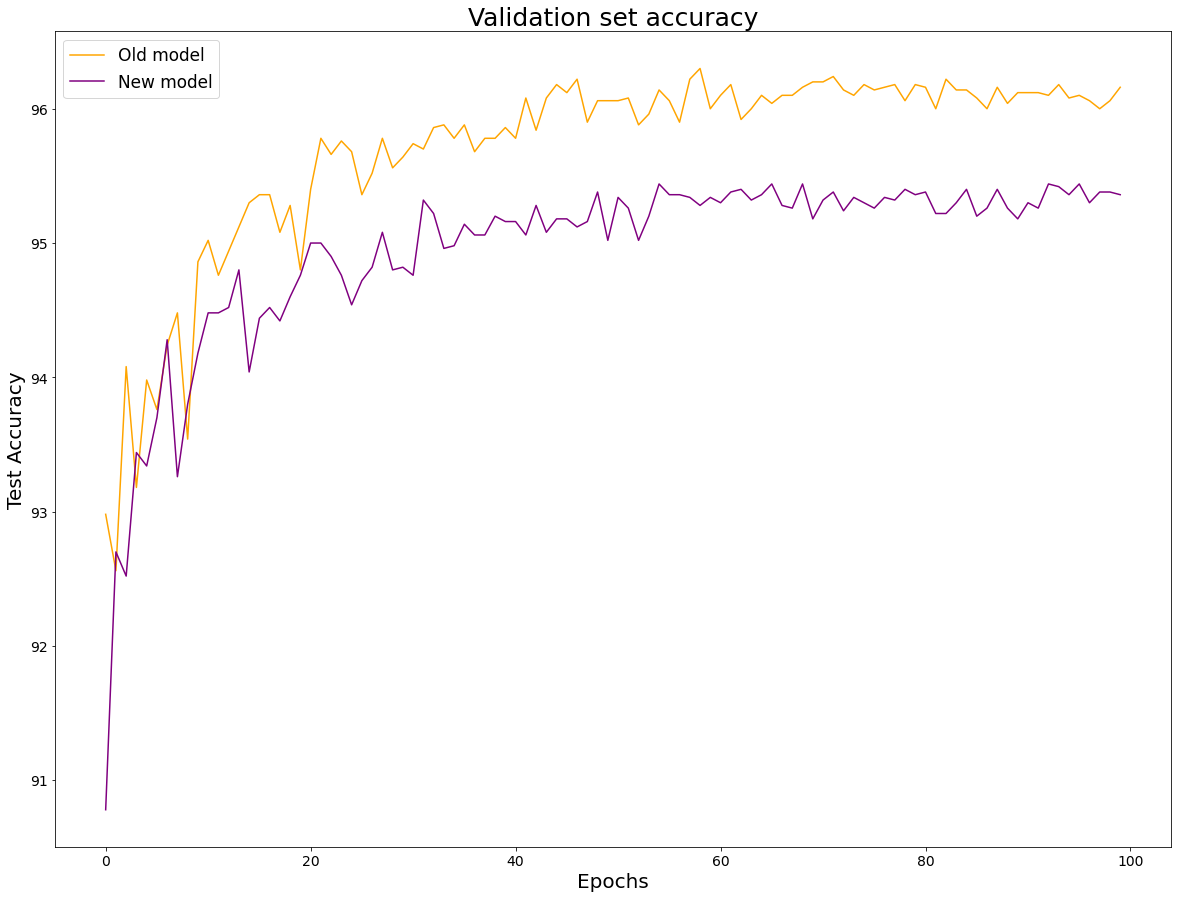

In [27]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_SL.testing_acc_Head_1.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_SL.testing_acc_Head_1.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Test Accuracy',fontsize=20);
ax.set_title('Validation set accuracy',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)

plt.show()

### analysis of NCD

In [28]:
## STEP 3
run_old_NCL = api.run("mhaggag96/trends_project/1ggpmba1").history()
run_new_NCL = api.run("mhaggag96/trends_project/2wov4ow5").history()
run_old_NCL_model = 'data/experiments/auto_novel/resnet_IL_cifar10_basic_config.pth'
run_new_NCL_model = 'data/experiments/auto_novel/resnet_IL_cifar10_new_config.pth'

In [29]:


def test(model, test_loader,args):
    # Put the model in evaluation mode
    model.eval()
    # Instantiate two numpy arrays, one for predictions and oen for targets
    preds = np.array([])
    targets = np.array([])
    acc_record = AverageMeter()  # track the accuracy of the first head
    # loss_record = AverageMeter()

    # Iterate for each batch in the dataloader
    for batch_idx, (x, label, _) in enumerate(tqdm(test_loader)):
        # Dataloader contain: X(input sample), label(sample label), index(index of sample in the original dataset)
        # We are interested in using just the sample x and its label to perform supervised learning
        x, label = x.to(device), label.to(device)

        # Output 1, Output2 and Output3 are the results of Head1, Head2, and features-layer4 respectively, we take the
        # outputs of the two heads since we are interested in testing the accuracy of one of the two
        output1, output2, _ = model(x)

        # If the argument head is 'head1' then we take as final output the result of the supervised head
        if args['head'] == 'head1':
            # output1 has size of (128,5), since the batch_size is 128 and the possible classes are 5
            output = output1
        # Otherwise, we take as final output the result of the unsupervised head
        else:
            output = output2
            # label-=args.num_labeled_classes

        # Returns the maximum value for each element in the input tensor, therefore we move from size (128,5) to (128)
        # Here we are not interested in the value, so we put '_' for the first term. We are interested in the second
        # term, which is the index of that value, since the index is equal to the predicted class for that input sample.
        _, pred = output.max(1)

        # Convert tensor to numpy using 'X.cpu.numpy', then append the value in the respective numpy array
        if args['head'] == 'head1':
            acc_testing = accuracy(output, label)  # calculating the accuracy
            acc_record.update(acc_testing[0].item(), x.size(0))
        else:
            acc_testing = 0
        targets = np.append(targets, label.cpu().numpy())
        preds = np.append(preds, pred.cpu().numpy())

    # Compute the accuracy metrics for the current test step, see supervised_learning.py for full explanation
    acc, nmi, ari = cluster_acc(targets.astype(int), preds.astype(int)), nmi_score(targets, preds), ari_score(targets,
                                                                                                              preds)

    print('Test cluster acc {:.4f}, nmi {:.4f}, ari {:.4f}, test accuracy {:.4f}'.format(acc, nmi, ari, acc_record.avg))
    return acc, nmi, ari, acc_record.avg

In [30]:
model=ResNet(BasicBlock, [2, 2, 2, 2], 5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load(run_old_NCL_model))
model_2 = resnet_sim(5, 5).to(device)
model_2.head1 = nn.Linear(512, 10).to(device)
model_2.load_state_dict(torch.load(run_new_NCL_model))

<All keys matched successfully>

In [31]:
unlabeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='train',
                                              aug=None, shuffle=False,
                                              target_list=range(5, 10))
unlabeled_eval_loader_test = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                                   aug=None, shuffle=False,
                                                   target_list=range(5, 10))
labeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                            aug=None, shuffle=False, target_list=range(5))

In [32]:
args={"head":"head2"}

In [33]:
args['head']

'head2'

In [34]:
test(model, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 196/196 [00:05<00:00, 37.26it/s]

Test cluster acc 0.9202, nmi 0.8320, ari 0.8201, test accuracy 0.0000


(0.9202, 0.8320104161918431, 0.8201387124443089, 0)

In [35]:
test(model, unlabeled_eval_loader_test,  args)


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.82it/s]

Test cluster acc 0.9146, nmi 0.8220, ari 0.8069, test accuracy 0.0000


(0.9146, 0.8219752618659001, 0.8068902802256295, 0)

In [36]:
test(model_2, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 196/196 [00:05<00:00, 37.99it/s]

Test cluster acc 0.9030, nmi 0.7918, ari 0.7812, test accuracy 0.0000


(0.90296, 0.7918218103415373, 0.7812178564442299, 0)

In [37]:
test(model_2, unlabeled_eval_loader_test,  args)


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 33.35it/s]


Test cluster acc 0.8970, nmi 0.7822, ari 0.7681, test accuracy 0.0000


(0.897, 0.7821943685816475, 0.7680634247203061, 0)

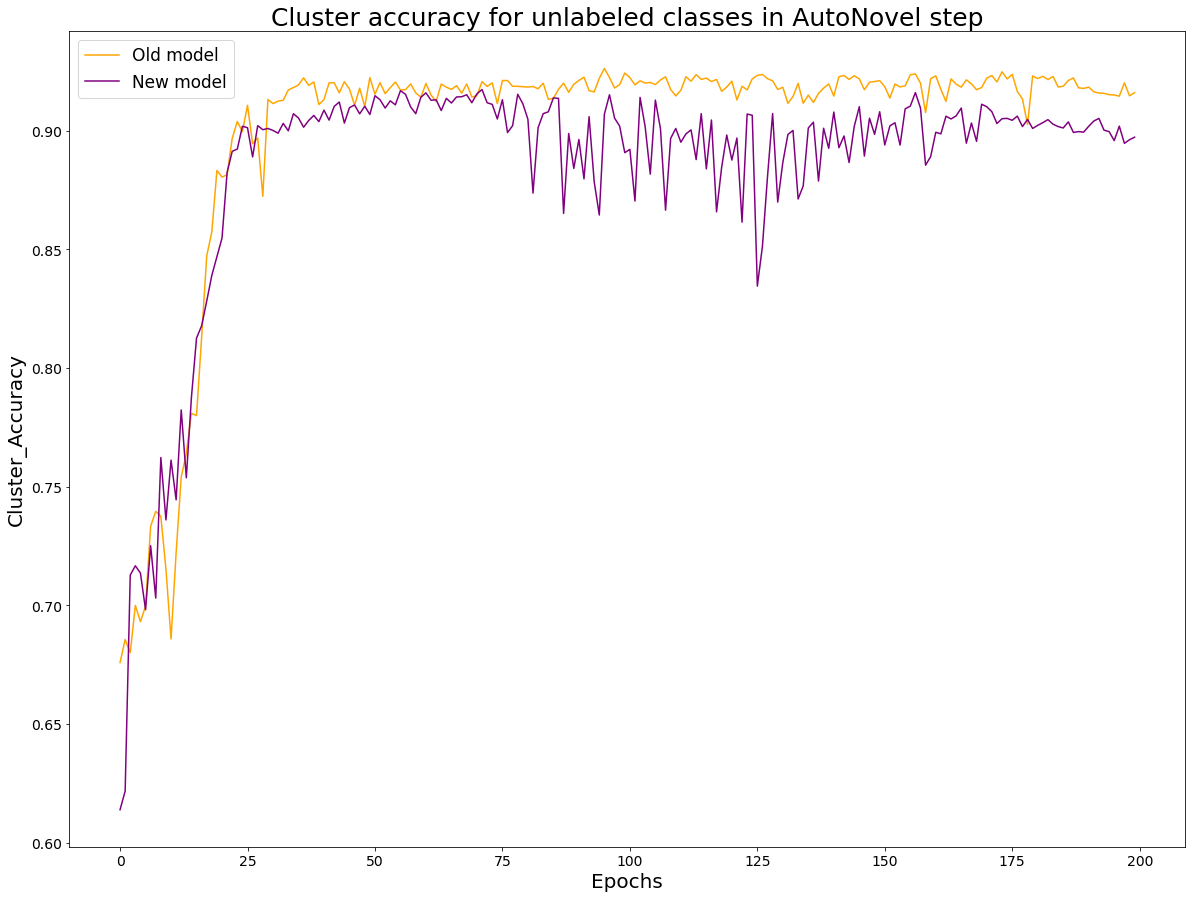

In [38]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_NCL.cluster_acc_Head_2.tolist(), color='orange',label="Old model") ;
ax.plot(run_new_NCL.cluster_acc_Head_2.tolist(), color='purple',label="New model") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Cluster_Accuracy',fontsize=20);
ax.set_title('Cluster accuracy for unlabeled classes in AutoNovel step',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Model_comparision_for_diff_resnet_AN_STEP.png')
plt.show()

## SSL methods


In [39]:
run_old_SL           = api.run("mhaggag96/trends_project/31c1ve1j").history()# to run it now worthy-pyramid-223
run_NCD_rotnet       = api.run("mhaggag96/trends_project/2wov4ow5").history()# 93_baseline_AN_new_resnet
run_NCD_barlow_twins = api.run("mhaggag96/trends_project/1gptquzl").history() # 111_barlow_twins_AN_normal_solo
run_NCD_simsiam      = api.run("mhaggag96/trends_project/2bbby7q3").history() # 113_simsiam_AN_normal_solo
run_NCD_supcon       = api.run("mhaggag96/trends_project/2nhzal8i").history()# 116_supcon_AN_normal_solo
run_NCD_swav         = api.run("mhaggag96/trends_project/1z0hmsra").history()# 122_swav_AN_normal_solo


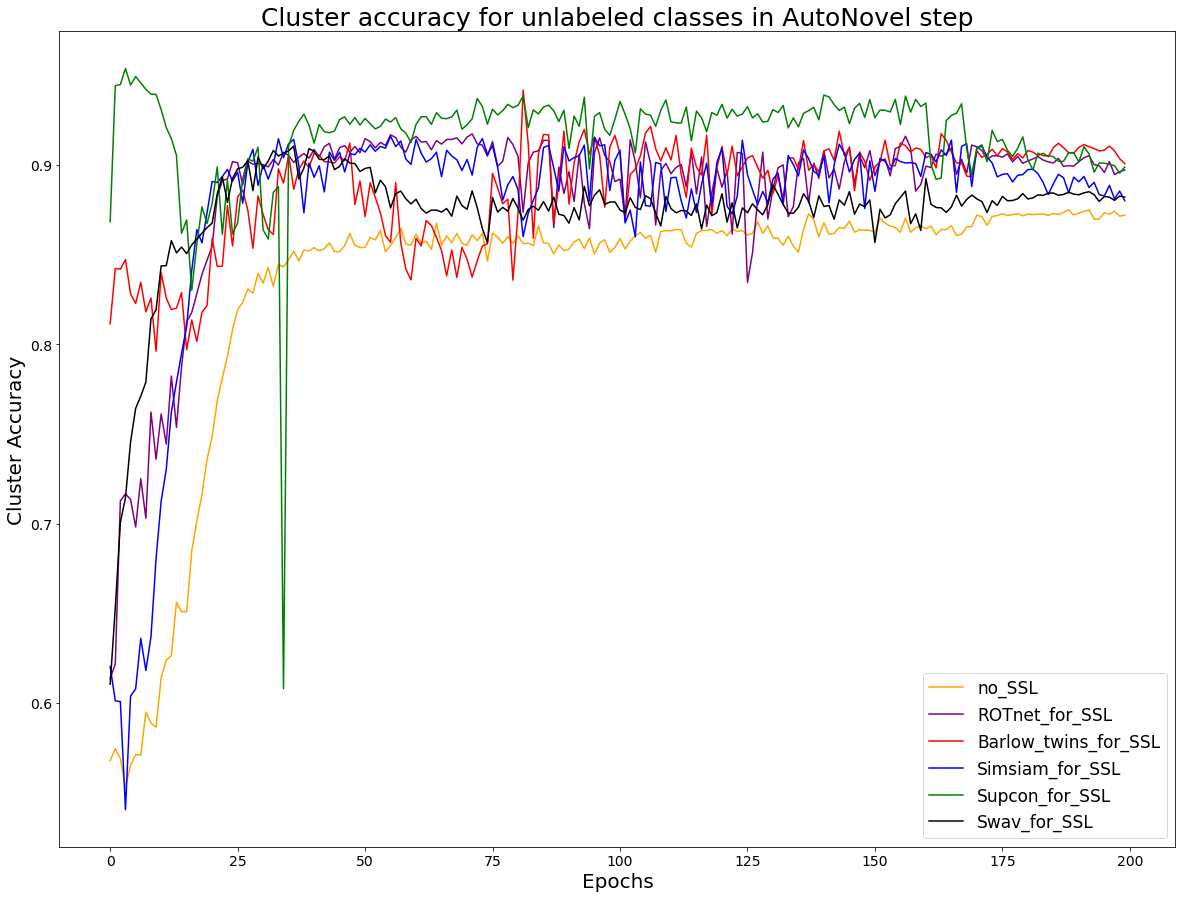

In [41]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_old_SL.cluster_acc_Head_2.tolist(), color='orange',label="no_SSL") ;
ax.plot(run_NCD_rotnet.cluster_acc_Head_2.tolist(), color='purple',label="ROTnet_for_SSL") ;
ax.plot(run_NCD_barlow_twins.cluster_acc_Head_2.tolist(), color='red',label="Barlow_twins_for_SSL") ;
ax.plot(run_NCD_simsiam.cluster_acc_Head_2.tolist(), color='blue',label="Simsiam_for_SSL") ;
ax.plot(run_NCD_supcon.cluster_acc_Head_2.tolist(), color='green',label="Supcon_for_SSL") ;
ax.plot(run_NCD_swav.cluster_acc_Head_2.tolist(), color='black',label="Swav_for_SSL") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Cluster Accuracy',fontsize=20);
# ax.set_title('Training unlabeled classes accuracy',fontsize=25);
ax.set_title('Cluster accuracy for unlabeled classes in AutoNovel step',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Model_comparision_for_diff_SSL_AN_STEP.png')

plt.show()

In [42]:
from models.resnet import BasicBlock,resnet_sim,ResNet
from utils.util import cluster_acc, Identity, AverageMeter, accuracy
from data.cifarloader import CIFAR10Loader, CIFAR10LoaderMix

In [43]:
def test(model, test_loader,args):
    # Put the model in evaluation mode
    model.eval()
    # Instantiate two numpy arrays, one for predictions and oen for targets
    preds = np.array([])
    targets = np.array([])
    acc_record = AverageMeter()  # track the accuracy of the first head
    # loss_record = AverageMeter()

    # Iterate for each batch in the dataloader
    for batch_idx, (x, label, _) in enumerate(tqdm(test_loader)):
        # Dataloader contain: X(input sample), label(sample label), index(index of sample in the original dataset)
        # We are interested in using just the sample x and its label to perform supervised learning
        x, label = x.to(device), label.to(device)

        # Output 1, Output2 and Output3 are the results of Head1, Head2, and features-layer4 respectively, we take the
        # outputs of the two heads since we are interested in testing the accuracy of one of the two
        output1, output2, _ = model(x)

        # If the argument head is 'head1' then we take as final output the result of the supervised head
        if args['head'] == 'head1':
            # output1 has size of (128,5), since the batch_size is 128 and the possible classes are 5
            output = output1
        # Otherwise, we take as final output the result of the unsupervised head
        else:
            output = output2
            # label-=args.num_labeled_classes

        # Returns the maximum value for each element in the input tensor, therefore we move from size (128,5) to (128)
        # Here we are not interested in the value, so we put '_' for the first term. We are interested in the second
        # term, which is the index of that value, since the index is equal to the predicted class for that input sample.
        _, pred = output.max(1)

        # Convert tensor to numpy using 'X.cpu.numpy', then append the value in the respective numpy array
        if args['head'] == 'head1':
            acc_testing = accuracy(output, label)  # calculating the accuracy
            acc_record.update(acc_testing[0].item(), x.size(0))
        else:
            acc_testing = 0
        targets = np.append(targets, label.cpu().numpy())
        preds = np.append(preds, pred.cpu().numpy())

    # Compute the accuracy metrics for the current test step, see supervised_learning.py for full explanation
    acc, nmi, ari = cluster_acc(targets.astype(int), preds.astype(int)), nmi_score(targets, preds), ari_score(targets,
                                                                                                              preds)

    print('Test cluster acc {:.4f}, nmi {:.4f}, ari {:.4f}, test accuracy {:.4f}'.format(acc, nmi, ari, acc_record.avg))
    return acc, nmi, ari, acc_record.avg

In [44]:
unlabeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='train',
                                              aug=None, shuffle=False,
                                              target_list=range(5, 10))
unlabeled_eval_loader_test = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                                   aug=None, shuffle=False,
                                                   target_list=range(5, 10))
labeled_eval_loader = CIFAR10Loader(root='./data/datasets/CIFAR/', batch_size=128, split='test',
                                            aug=None, shuffle=False, target_list=range(5))

In [45]:
run_new_NCL_model=[ 'resnet_IL_cifar10_NO_rotnet.pth','resnet_IL_cifar10_new_config.pth',
                    'resnet_IL_cifar10_Barlow_twins_2.pth','resnet_IL_cifar10_simsam_2.pth',
                   'resnet_IL_cifar10_supcon_2.pth','resnet_IL_cifar10_swav_2.pth']

In [46]:
args={"head":"head2"}

* baseline for no ssl for new arhiecture

In [47]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[0]))

<All keys matched successfully>

In [48]:
test(model, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 196/196 [00:05<00:00, 37.68it/s]

Test cluster acc 0.8720, nmi 0.7188, ari 0.7180, test accuracy 0.0000


(0.87204, 0.7187877924116777, 0.7180272228004314, 0)

In [49]:
test(model, unlabeled_eval_loader_test,  args)


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 33.61it/s]

Test cluster acc 0.8670, nmi 0.7162, ari 0.7098, test accuracy 0.0000


(0.867, 0.7162400239242122, 0.7097863057616941, 0)

* baseline for new archiecture using rotnet

In [50]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[1]))

<All keys matched successfully>

In [51]:
test(model, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 196/196 [00:05<00:00, 38.13it/s]


Test cluster acc 0.9030, nmi 0.7918, ari 0.7812, test accuracy 0.0000


(0.90296, 0.7918218103415373, 0.7812178564442299, 0)

In [52]:
test(model, unlabeled_eval_loader_test,  args)


100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 33.14it/s]

Test cluster acc 0.8970, nmi 0.7822, ari 0.7681, test accuracy 0.0000


(0.897, 0.7821943685816475, 0.7680634247203061, 0)

* Barlow-twins ssl for step 3 

In [53]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[2]))

<All keys matched successfully>

In [54]:
test(model, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 196/196 [00:05<00:00, 37.78it/s]


Test cluster acc 0.9008, nmi 0.7865, ari 0.7714, test accuracy 0.0000


(0.9008, 0.7865403434067029, 0.7714221789928883, 0)

In [56]:
test(model, unlabeled_eval_loader_test,  args)

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.41it/s]

Test cluster acc 0.8978, nmi 0.7854, ari 0.7659, test accuracy 0.0000


(0.8978, 0.7853940901078657, 0.7659084291624052, 0)

* simsam ssl for step 3 

In [57]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[3]))

<All keys matched successfully>

In [58]:
test(model, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 196/196 [00:05<00:00, 37.47it/s]

Test cluster acc 0.8802, nmi 0.7550, ari 0.7314, test accuracy 0.0000


(0.8802, 0.7550372268105576, 0.7314406284970413, 0)

In [60]:
test(model, unlabeled_eval_loader_test,  args)

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.55it/s]

Test cluster acc 0.8742, nmi 0.7420, ari 0.7197, test accuracy 0.0000


(0.8742, 0.7420304260709691, 0.7196610136480078, 0)

* Supcon ssl for step 3 

In [61]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[4]))

<All keys matched successfully>

In [62]:
test(model, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 196/196 [00:05<00:00, 37.93it/s]

Test cluster acc 0.8989, nmi 0.8427, ari 0.8018, test accuracy 0.0000


(0.89892, 0.8427314334000399, 0.801791106458013, 0)

In [63]:
test(model, unlabeled_eval_loader_test,  args)

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.78it/s]

Test cluster acc 0.8872, nmi 0.8185, ari 0.7793, test accuracy 0.0000


(0.8872, 0.8185231186538177, 0.7793495179105123, 0)

* Swav ssl for step 3 

In [64]:
model = resnet_sim(5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/'+run_new_NCL_model[5]))

<All keys matched successfully>

In [65]:
test(model, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 196/196 [00:05<00:00, 37.63it/s]


Test cluster acc 0.8822, nmi 0.7820, ari 0.7590, test accuracy 0.0000


(0.8822, 0.7820056033504533, 0.7589998603342397, 0)

In [66]:
test(model, unlabeled_eval_loader_test,  args)

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 32.98it/s]


Test cluster acc 0.8734, nmi 0.7723, ari 0.7452, test accuracy 0.0000


(0.8734, 0.7723317733293279, 0.7452054213356883, 0)

## Domain adaptation

In [67]:
from data.MNISIT_loader import MNISITLoader, MNISITLoaderMix,MNISITLoader_main, MNISITLoaderMix_main


In [68]:
unlabeled_eval_loader = MNISITLoader_main( batch_size=128, split='train', aug=None,
                                           shuffle=False, catego='unlabeled',number_of_classes=5)
unlabeled_eval_loader_test = MNISITLoader_main( batch_size=128, split='test',
                                                aug=None, shuffle=False,catego='unlabeled',
                                                number_of_classes=5)

In [69]:
run_MNISIT_BASELINE           = api.run("mhaggag96/trends_project/2maa3o72").history()# 210-MNISIT-BL
run_MNISIT_MIXED              = api.run("mhaggag96/trends_project/3fc3cw36").history()# 187-MNISIT

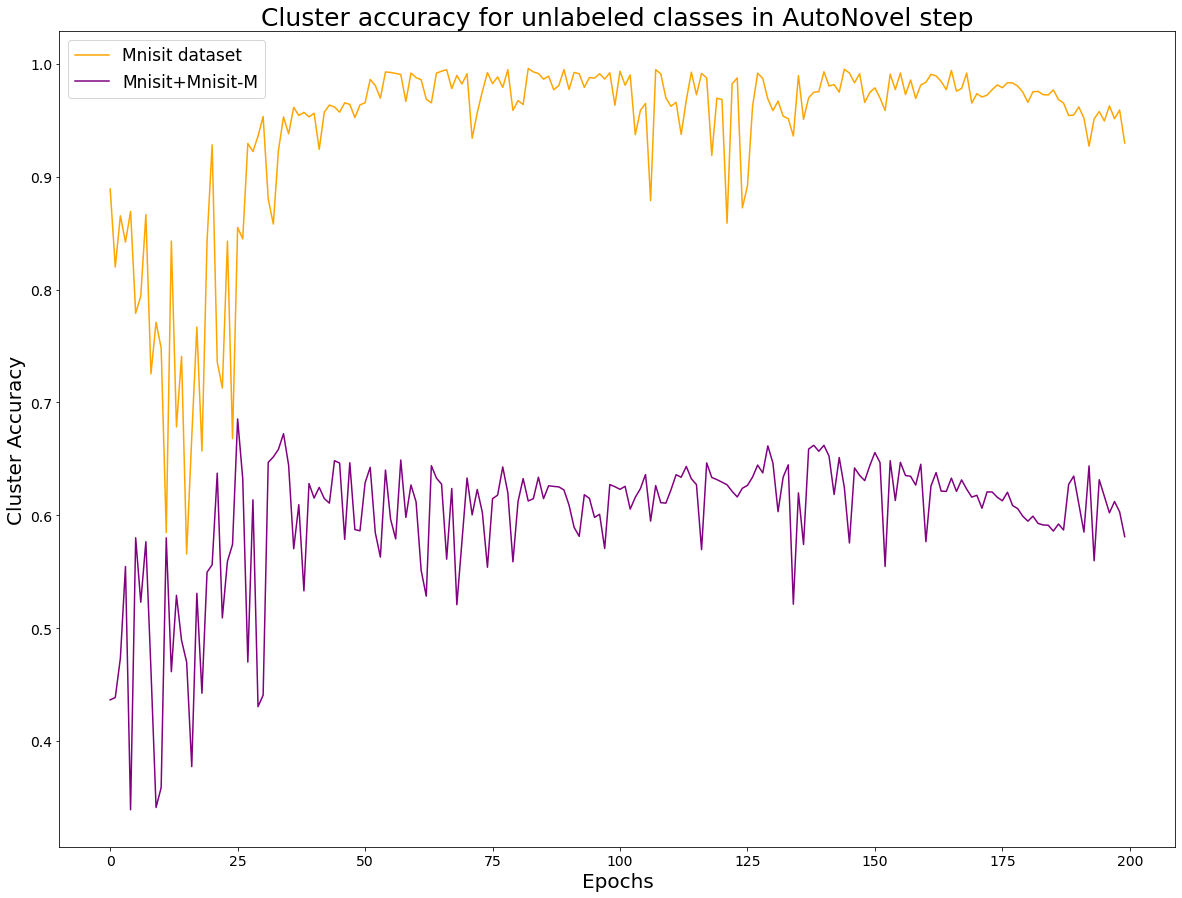

In [71]:
fig, ax= plt.subplots(figsize=(20, 15));
ax.plot(run_MNISIT_BASELINE.cluster_acc_Head_2.tolist(), color='orange',label="Mnisit dataset") ;
ax.plot(run_MNISIT_MIXED.cluster_acc_Head_2.tolist(), color='purple',label="Mnisit+Mnisit-M") ;

ax.set_xlabel('Epochs',fontsize=20);
ax.set_ylabel('Cluster Accuracy',fontsize=20);
ax.set_title('Cluster accuracy for unlabeled classes in AutoNovel step',fontsize=25);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', framealpha=0.8,fontsize=17)
plt.savefig('images/Model_comparision_for_diff_DA_AN_STEP.png')
plt.show()

In [72]:
unlabeled_eval_loader = MNISITLoader_main( batch_size=128, split='train', aug=None,
                                           shuffle=False, catego='unlabeled',number_of_classes=5)
unlabeled_eval_loader_test = MNISITLoader_main( batch_size=128, split='test',
                                                aug=None, shuffle=False,catego='unlabeled',
                                                number_of_classes=5)

In [73]:
model=ResNet(BasicBlock, [2, 2, 2, 2], 5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/resnet_IL_minsiit_baseline.pth'))

<All keys matched successfully>

In [74]:
test(model, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 230/230 [00:06<00:00, 37.87it/s]


Test cluster acc 0.9299, nmi 0.8800, ari 0.8553, test accuracy 0.0000


(0.9299074955788328, 0.8799914748745147, 0.8553017736460761, 0)

In [75]:
test(model, unlabeled_eval_loader_test,  args)

100%|███████████████████████████████████████████| 38/38 [00:01<00:00, 32.48it/s]

Test cluster acc 0.9243, nmi 0.8779, ari 0.8478, test accuracy 0.0000


(0.9242954124665707, 0.8778894788619004, 0.8477671731017574, 0)

In [76]:
model=ResNet(BasicBlock, [2, 2, 2, 2], 5, 5).to(device)
model.head1 = nn.Linear(512, 10).to(device)
model.load_state_dict(torch.load('data/experiments/auto_novel/resnet_IL_minsiit_mix.pth'))

<All keys matched successfully>

In [77]:
unlabeled_eval_loader = MNISITLoader( batch_size=128, split='train', aug=None,
                                           shuffle=False, catego='unlabeled',number_of_classes=5)
unlabeled_eval_loader_test = MNISITLoader( batch_size=128, split='test',
                                                aug=None, shuffle=False,catego='unlabeled',
                                                number_of_classes=5)

In [78]:
test(model, unlabeled_eval_loader,  args)


100%|█████████████████████████████████████████| 230/230 [00:06<00:00, 38.02it/s]


Test cluster acc 0.5811, nmi 0.4878, ari 0.3935, test accuracy 0.0000


(0.5811454223915113, 0.4878164319080536, 0.3934781324055224, 0)

In [79]:
test(model, unlabeled_eval_loader_test,  args)

100%|███████████████████████████████████████████| 38/38 [00:01<00:00, 32.49it/s]

Test cluster acc 0.5733, nmi 0.4781, ari 0.3735, test accuracy 0.0000


(0.5733388191730097, 0.47805562852007855, 0.37348476956058746, 0)